In [2]:
import poppy
import poppy.accel_math as am
print(am._USE_NUMEXPR)
print(am._USE_FFTW)
print(am._USE_MKL)
print(am._USE_OPENCL)
print(am._USE_CUDA)
poppy.conf.use_numexpr = True
poppy.conf.use_fftw = False
poppy.conf.use_mkl = True
poppy.conf.use_opencl = True
poppy.conf.use_cuda = False

True
True
True
True
False


In [8]:
import numpy as np
import astropy.units as u
from pathlib import Path
from importlib import reload

import poppy_roman_cgi_phasec as cgi
from poppy_roman_cgi_phasec import spc
from poppy_roman_cgi_phasec import misc
reload(spc)

import logging, sys
_log = logging.getLogger('poppy')
_log.setLevel("DEBUG")
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

wavelengths = np.linspace(730e-9 - 730e-9*.15/2, 730e-9 + 730e-9*.15/2,11)*u.m
cgi_dir = Path('C:/Users/Kian/Desktop/roman-cgi-phasec-data')

psfs, wfs = spc.run_multi(mode='SPC730',
                          npsf=256, psf_pixelscale_lamD=0.1,
                          cgi_dir=cgi_dir,
                          use_fpm=False,
#                           wavelengths=wavelengths,
#                           return_intermediates=True,
                         )

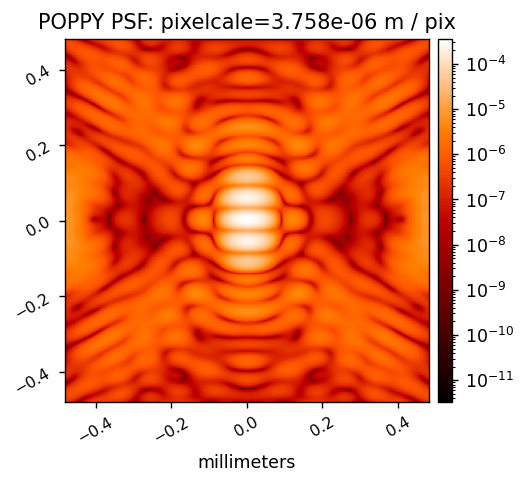

In [9]:
psf_multi = 0
for psf in psfs: psf_multi += psf.data
psf_multi /= len(psfs)

misc.myimshow(psf_multi, 'POPPY PSF: pixelcale={:.3e}'.format(wfs[0][-1].pixelscale),
              pxscl=wfs[0][-1].pixelscale.to(u.mm/u.pix),
              lognorm=True, cmap='gist_heat')

In [5]:
import proper
import roman_phasec_proper

cor_type = 'spc-spec'
lam_array = np.array([0.730])
# lam_array = np.array([0.770])
lam_array = np.linspace(.730 - .730*.15/2, .730 + .730*.15/2,11)

n = 256                 # output image dimension (must be power of 2)
final_sampling = 0.1    # output sampling in lam0/D

xoffset = 0
use_fpm = 1
polaxis = 0
use_pupil_defocus = 0

use_errors = 0
use_dms = 0
if use_dms==1: 
    use_dm1 = 1
    use_dm2 = 1
    if cor_type=='spc-spec':
        dm1 = proper.prop_fits_read( roman_phasec_proper.lib_dir + '\\examples\\spc_spec_band3_best_contrast_dm1.fits' )
        dm2 = proper.prop_fits_read( roman_phasec_proper.lib_dir + '\\examples\\spc_spec_band3_best_contrast_dm2.fits' )
        print('Loaded DMs.')
    elif cor_type=='spc-wide':
        dm1 = proper.prop_fits_read( roman_phasec_proper.lib_dir + '\\examples\\spc_wide_band4_best_contrast_dm1.fits' )
        dm2 = proper.prop_fits_read( roman_phasec_proper.lib_dir + '\\examples\\spc_wide_band4_best_contrast_dm2.fits' )
        print('Loaded DMs.')
else: 
    use_dm1 = 0
    use_dm2 = 0
    dm1 = 0
    dm2 = 0
    print('No DMs loaded.')
    
(proper_wfs, proper_samplings_m) = proper.prop_run_multi('roman_phasec', lam_array, n, QUIET=False, 
                                                PASSVALUE={'cor_type':cor_type,
                                                           'final_sampling_lam0':final_sampling, 
                                                           'source_x_offset':xoffset,
                                                           'use_fpm':use_fpm,
                                                           'use_errors': use_errors,
                                                           'use_pupil_defocus':use_pupil_defocus,
                                                           'use_dm1':use_dm1, 'dm1_m':dm1, 
                                                           'use_dm2':use_dm2, 'dm2_m':dm2,
                                                           'polaxis':polaxis,
                                                          })

No DMs loaded.


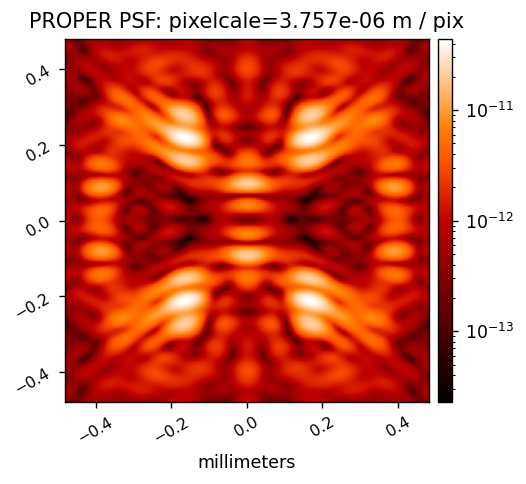

In [6]:
proper_psfs = np.abs(proper_wfs)**2

proper_psf = np.sum( proper_psfs, 0 ) / len(lam_array)
proper_sampling_m = proper_samplings_m[0]*u.m/u.pix

misc.myimshow(proper_psf, 'PROPER PSF: pixelcale={:.3e}'.format(proper_sampling_m), 
              pxscl=proper_sampling_m.to(u.mm/u.pix), lognorm=True, cmap='gist_heat')

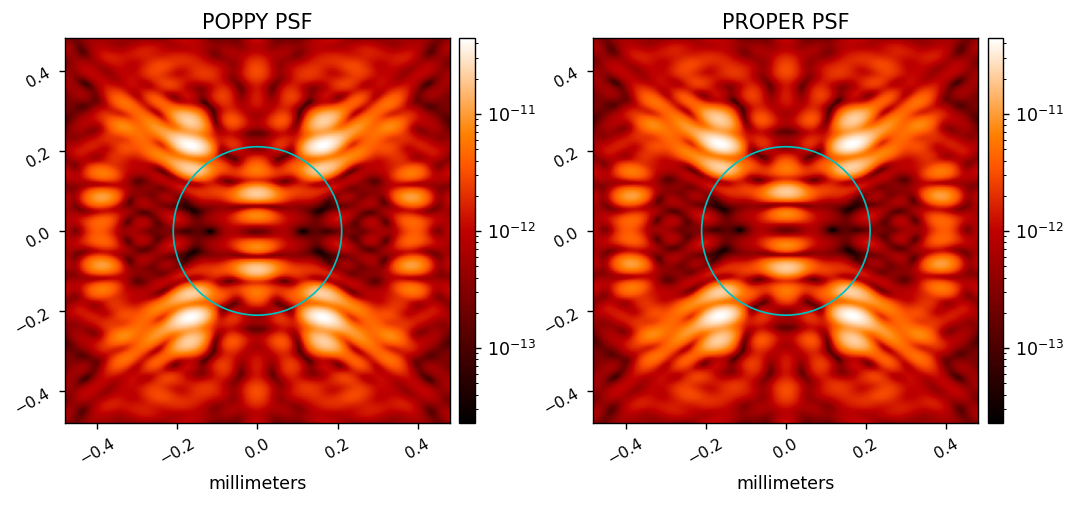

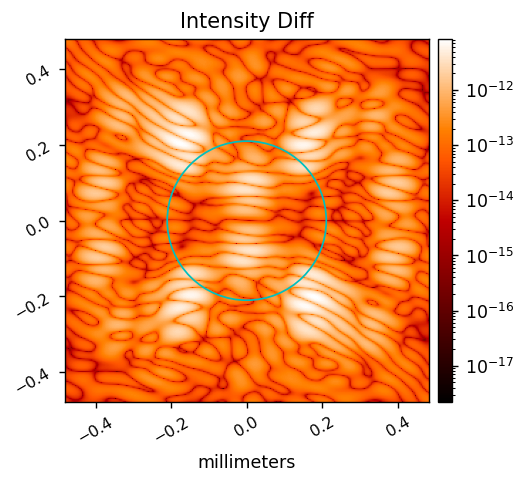

3.968775908721199e-13
1.6857014938939983e-07
1.685730051597297e-07


In [7]:
from scipy.ndimage import rotate
from matplotlib.patches import Circle

pop_int = rotate(psf_multi,180)
prop_int = proper_psf

iwa=5.6
owa=20.4
pop_int = misc.mask_psf(pop_int, pixelscale=wfs[0][-1].pixelscale.value, pixelscale_lamD=0.1, iwa=None, owa=owa)
prop_int = misc.mask_psf(prop_int, pixelscale=proper_sampling_m.value, pixelscale_lamD=0.1, iwa=None, owa=owa)

psfs = np.ma.concatenate([pop_int, prop_int])
vmin=np.ma.min(psfs)
vmax=np.ma.max(psfs)
# vmax = 1e-12
# vmin = 1e-18

innwa = iwa/final_sampling*proper_sampling_m.value * 1000 # inner and outer working angles in units of m
outwa = owa/final_sampling*proper_sampling_m.value * 1000
patches1 = [Circle((0,0),innwa,edgecolor='c', facecolor='none',lw=1),
            Circle((0,0),outwa,edgecolor='c', facecolor='none',lw=1)]
patches2 = [Circle((0,0),innwa,edgecolor='c', facecolor='none',lw=1),
            Circle((0,0),outwa,edgecolor='c', facecolor='none',lw=1)]
misc.myimshow2(pop_int, prop_int, 'POPPY PSF', 'PROPER PSF',
               cmap1='gist_heat', cmap2='gist_heat', 
               lognorm1=True, lognorm2=True, vmin1=vmin, vmax1=vmax, vmin2=vmin, vmax2=vmax,
               pxscl=proper_sampling_m.to(u.mm/u.pix),
               patches1=patches1, patches2=patches2)

# Difference
int_diff = np.abs(pop_int-prop_int)
patches = [Circle((0,0),innwa,edgecolor='c', facecolor='none',lw=1),
            Circle((0,0),outwa,edgecolor='c', facecolor='none',lw=1)]
misc.myimshow(int_diff, 'Intensity Diff',
               pxscl=proper_sampling_m.to(u.mm/u.pix),
               lognorm=True, cmap='gist_heat',  patches=patches,)
print(np.ma.mean(int_diff))
print(np.ma.sum(pop_int))
print(np.ma.sum(prop_int))